## Importing Libraries

In [1]:
import numpy as np
import copy

from utils import *
from pylops.waveeqprocessing.twoway import  AcousticWave2D

from copy import deepcopy
from numpy.linalg import norm
from devito import configuration

from time import time
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Initializing Model Parameters

The foundation of **Pylops** functionality lies in the use of operators, in this case, the 2D acoustic operator (**AcousticWave2D**). This operator wraps **DEVITO** objects, such as SeismicModel—which includes the velocity model, time step (dt), and other details—and Geometry, which contains all the necessary geometry information, such as receiver and source coordinates.

By encapsulating these objects, users only need to focus on the parameters to be applied, rather than on how the underlying objects are built.

Below are the parameters required for creating the **AcousticWave2D** operator.

In [2]:
# Modelling parameters (in meters, seconds and Hz)
par = {
    'nx': 369,   'dx': 25.,    'ox': 2,
    'nz': 375,   'dz': 8.,     'oz': 0,
    'ns': 50,    'ds': 175,    'sz': 1,
    'nr': 369,   'dr': 25,     'rz': 1,
    'nt': 5000,  'dt': 0.0008, 't0': 0.,
    'nw': 30,    'freq': 17
}

shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
src_type = 'Ricker'
dtype = np.float32
space_order = 32
nbl = 40

In [3]:
# Setting model velocity path
path_true_model="data/model-t.bin"

# Loading model velocity
vp = (np.fromfile(path_true_model, np.float32)/1000).reshape(par['nx'], par['nz'])

# Applying water layer
msk = create_mask_value(vp, 1.52)
vp_min = np.min(vp)
vp_max = np.max(vp)

# Generating initial model
sigma = [15,10] 
vp0 = gaussian_filter(vp,sigma=sigma)

vp0[:, 0:par['nw']] = 1.52
vp[:, 0:par['nw']] = 1.52

domain_x = (shape[0]-1) * spacing[0]

# Setting receivers positions
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] # receivers positions
x_r[:, 1] = par['rz']

# Setting source positions
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] # source positions
x_s[:, 1] = par['sz']

# Setting propagation time
tn = (np.arange(par['nt'])*par['dt'])[-1]

# Creating modelling operator
Dop = AcousticWave2D(shape=shape, origin=origin, spacing=spacing, vp=vp*1000, nbl=nbl, 
                     space_order=space_order,
                    src_x=x_s[:,0], src_z=x_s[:,1], rec_x=x_r[:,0], rec_z=x_r[:,1], t0=par['t0'], tn=tn*1000,
                     src_type=src_type, f0=par['freq'], dtype=dtype,op_name="fwd")

dt = Dop.model.critical_dt
nt = Dop.geometry.nt

vp_true = deepcopy(vp)
vp_init = deepcopy(vp0) 

Operator `initdamp` ran in 0.01 s
INFO: Operator `initdamp` ran in 0.01 s


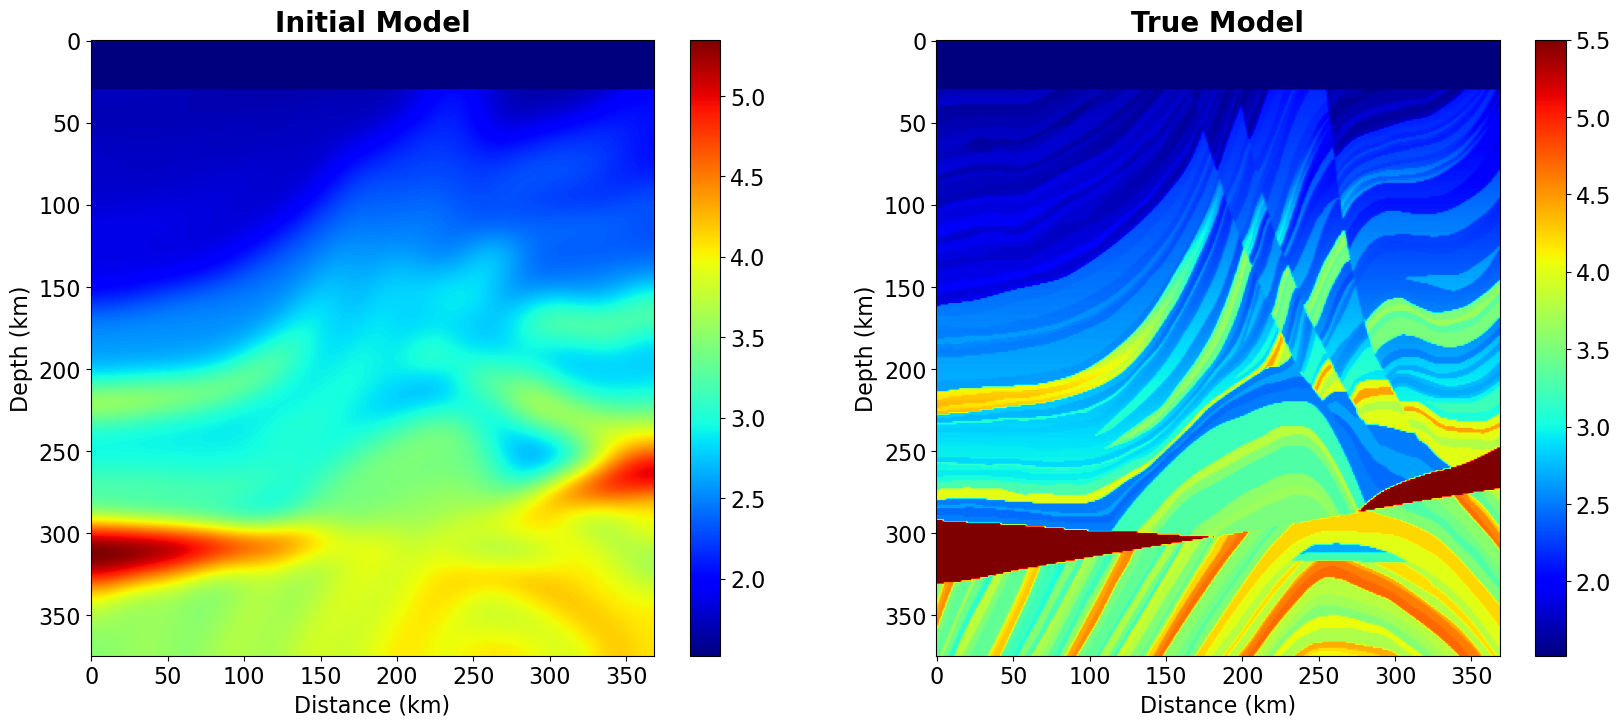

In [4]:
# Plotting velocity models
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(vp_init.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('Initial Model', fontsize=20, fontweight='bold')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(vp_true.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('True Model', fontsize=20, fontweight='bold')
plt.colorbar()

##  Generating Observed Data (Dobs)

Pylops performs forward propagation as follows:

$dobs = Dop * vptrue$, 

where $m$ represents the velocity value $vp$ em m/s.

In [5]:
dobs = Dop * vp_true

Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.92 s
INFO: Operator `Forward` ran in 0.92 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in

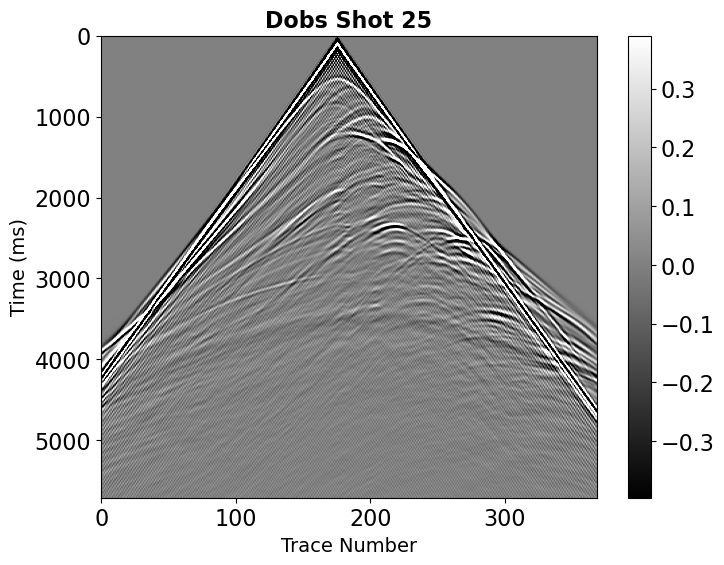

In [10]:
# Plotting Observed Data
shot_dobs = 25
plot_data(dobs,shot=shot_dobs, title=f'Dobs Shot {shot_dobs}')

## Generating Calculated Data (Dcalc)

Assuming that the target wavelet is known, we must generate calculated data for the filtering frequency, in order to obtain the target wavelet from the **AcousticWave2D** operator.

In [13]:
f = 5
AWD = AcousticWave2D(shape=shape, origin=origin, spacing=spacing, vp=vp*1000, nbl=nbl, 
                     space_order=space_order, src_x=x_s[:,0], src_z=x_s[:,1], 
                     rec_x=x_r[:,0], rec_z=x_r[:,1], t0=par['t0'], tn=tn*1000,
                     src_type=src_type, f0=f, dtype=dtype,op_name="fwd")

dcalc = AWD * vp_true

Operator `initdamp` ran in 0.01 s
INFO: Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.89 s
INFO: Operator `Forward` ran in 0.89 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.93 s
INFO: Operator `Forward` ran in 0.93 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.90 s
INFO: Operator `Forward` ran in 0.90 s
Operator `Forward` ran in 0.93 s
INFO: Operator `Forward` ran 

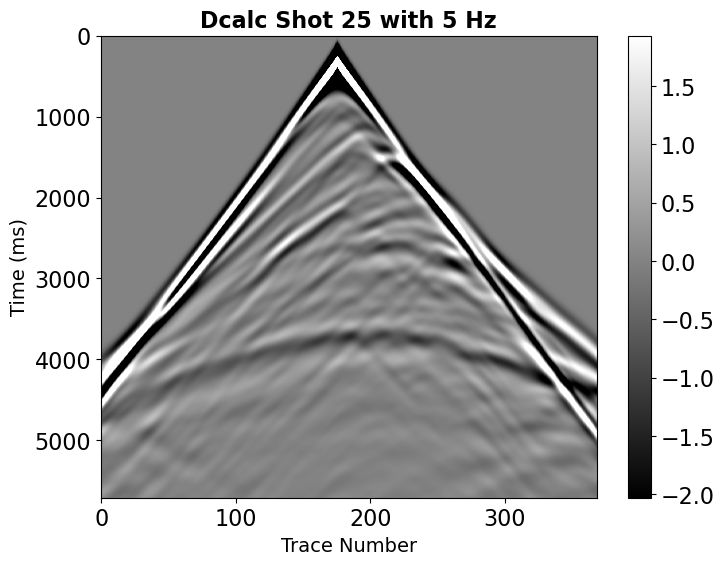

In [15]:
# Plotting Calculated Data
shot_dcalc = 25
plot_data(dcalc,shot=shot_dcalc, title=f'Dcalc Shot {shot_dcalc} with {f} Hz')

## Wiener Filt 

To compute the Wiener filter, it is necessary to know the wavelet observed (wavelet that were used to genered observed data), the observed data (dobs) and the target wavelet (in this case, the wavelet that were used to generate calculated data).

In [16]:
#observed wavelet
wav_dobs = Dop.geometry.src.wavelet
#target wavelet
wav_targ = AWD.geometry.src.wavelet
#computing wiener filt
d_filt = Wiener_Filt(wav_dobs, wav_targ, dobs)

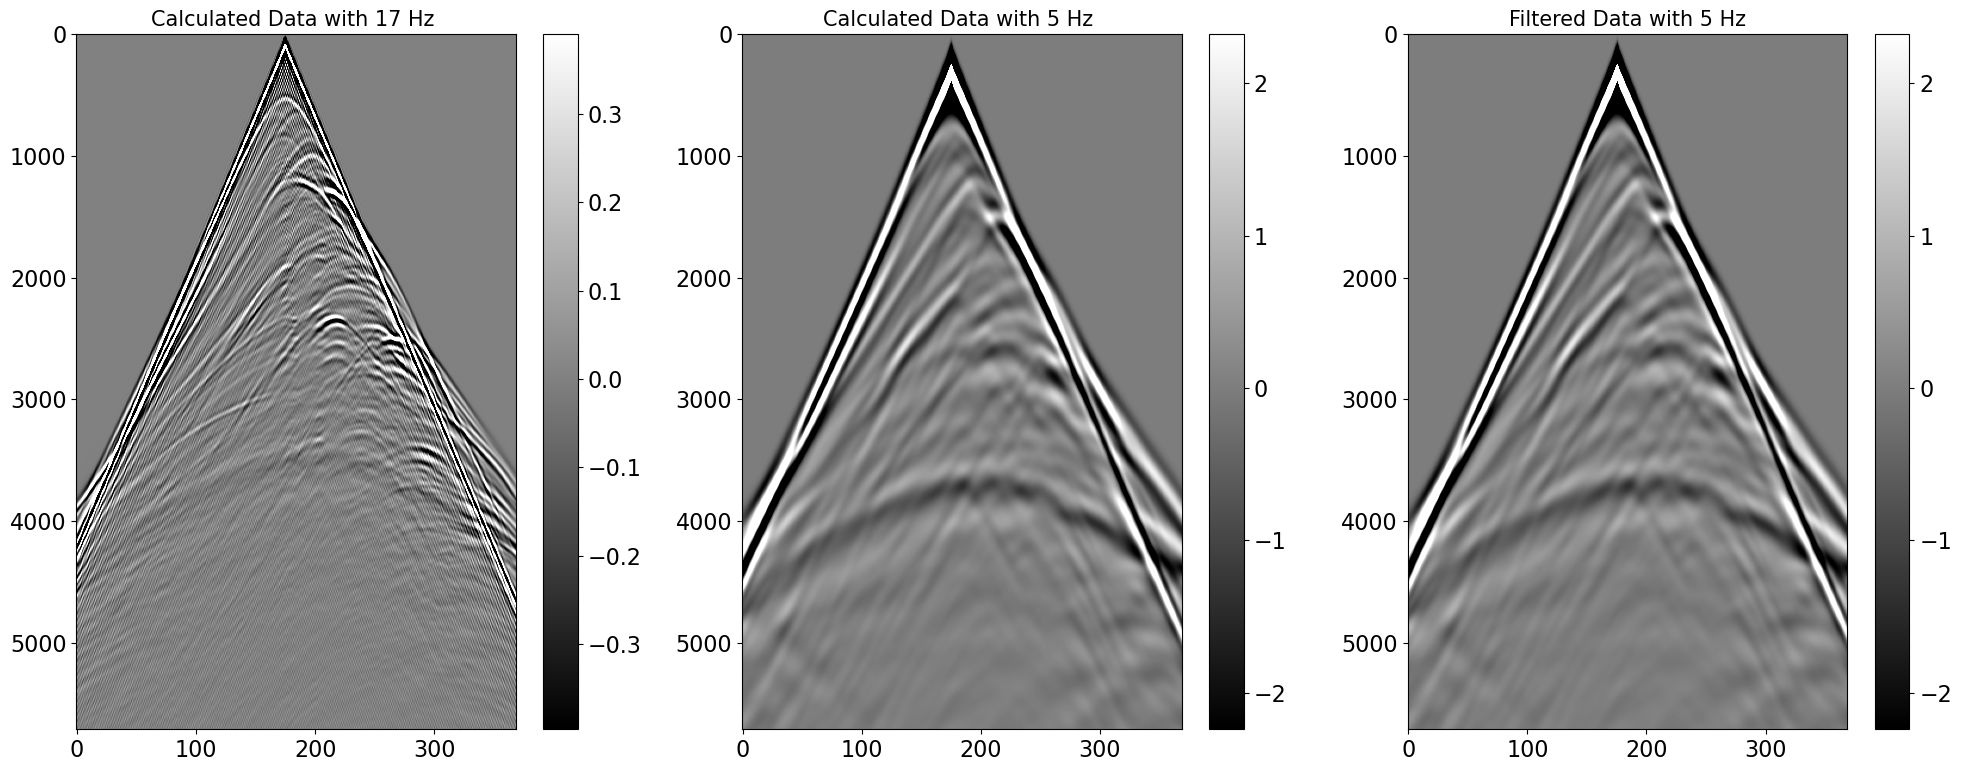

In [18]:
# Plotting Results from Wiener Filt
vminfilt, vmaxfilt = np.percentile(np.hstack(dcalc[shot]).ravel(), [2, 98])
f_vmin, f_vmax = np.percentile(np.hstack(d_filt[shot]).ravel(), [2, 98])

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])
plt.imshow(dobs[shot].T,aspect='auto',cmap='gray',vmin=d_vmin,vmax=d_vmax)
plt.title(f'Calculated Data with {par["freq"]} Hz ',fontsize=15)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(dobs_5hz[shot].T,aspect='auto',cmap='gray',vmin=vminfilt, vmax=vmaxfilt)
plt.title(f'Calculated Data with {f} Hz ',fontsize=15)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(d_filt[shot].T,aspect='auto',cmap='gray',vmin=f_vmin, vmax=f_vmax)
plt.title(f'Filtered Data with {f} Hz',fontsize=15)
plt.colorbar()
plt.tight_layout()